In [1]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install feature-engine

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import pandas as pd
import os
import warnings

import xgboost as xgb

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

In [4]:
pd.set_option("display.max_columns",None)
# this commands displays all the columns regardless of their numbers

In [5]:
sklearn.set_config(transform_output="pandas")

In [6]:
warnings.filterwarnings("ignore")

In [7]:
train = pd.read_csv("data/train_.csv")
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-05-27,Delhi,Cochin,20:55:00,12:35:00,940,1.0,In-flight meal not included,12898
1,Jet Airways,2019-06-12,Kolkata,Banglore,18:55:00,16:20:00,1285,1.0,No info,13044
2,Air India,2019-05-18,Delhi,Cochin,09:45:00,09:25:00,1420,2.0,No info,10975
3,Indigo,2019-06-03,Mumbai,Hyderabad,21:20:00,22:50:00,90,0.0,No info,2227
4,Jet Airways,2019-04-01,Mumbai,Hyderabad,02:55:00,04:20:00,85,0.0,No info,5678
...,...,...,...,...,...,...,...,...,...,...
6689,Spicejet,2019-06-09,Kolkata,Banglore,11:35:00,18:50:00,435,1.0,No info,8479
6690,Multiple Carriers,2019-05-09,Delhi,Cochin,10:00:00,01:30:00,930,1.0,No info,15078
6691,Air India,2019-05-18,Delhi,Cochin,12:00:00,07:40:00,1180,2.0,No info,8603
6692,Air Asia,2019-05-18,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No info,8759


In [8]:
val = pd.read_csv("data/val_.csv")
val

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-05-27,Delhi,Cochin,09:00:00,19:00:00,600,1.0,In-flight meal not included,10675
1,Jet Airways,2019-05-24,Kolkata,Banglore,18:55:00,10:05:00,910,1.0,In-flight meal not included,8586
2,Jet Airways,2019-03-18,Banglore,New Delhi,21:25:00,09:30:00,725,1.0,No info,13555
3,Spicejet,2019-06-27,Chennai,Kolkata,17:45:00,20:05:00,140,0.0,No check-in baggage included,3543
4,Air Asia,2019-05-15,Kolkata,Banglore,07:35:00,19:25:00,710,1.0,No info,5192
...,...,...,...,...,...,...,...,...,...,...
1669,Vistara,2019-05-06,Kolkata,Banglore,07:10:00,22:40:00,930,1.0,No info,8452
1670,Indigo,2019-04-03,Delhi,Cochin,21:05:00,00:20:00,195,0.0,No info,5021
1671,Air India,2019-03-01,Banglore,New Delhi,17:00:00,19:45:00,165,0.0,No info,23017
1672,Air India,2019-06-18,Mumbai,Hyderabad,06:20:00,07:40:00,80,0.0,No info,3100


In [9]:
test = pd.read_csv("data/test_.csv")
test

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-06,Banglore,New Delhi,08:00:00,08:15:00,1455,1.0,No info,17996
1,Spicejet,2019-06-06,Kolkata,Banglore,22:20:00,00:40:00,140,0.0,No info,3873
2,Indigo,2019-03-18,Kolkata,Banglore,05:30:00,08:20:00,170,0.0,No info,4462
3,Jet Airways,2019-03-24,Mumbai,Hyderabad,15:50:00,17:20:00,90,0.0,In-flight meal not included,2228
4,Spicejet,2019-04-27,Banglore,Delhi,09:30:00,12:20:00,170,0.0,No info,4991
...,...,...,...,...,...,...,...,...,...,...
2088,Jet Airways,2019-05-27,Delhi,Cochin,19:15:00,12:35:00,1040,1.0,In-flight meal not included,12898
2089,Jet Airways,2019-05-27,Delhi,Cochin,02:15:00,19:00:00,1005,1.0,In-flight meal not included,12898
2090,Jet Airways,2019-06-03,Delhi,Cochin,02:15:00,04:25:00,1570,1.0,In-flight meal not included,11627
2091,Multiple Carriers,2019-06-06,Delhi,Cochin,15:15:00,01:30:00,615,1.0,No info,6795


In [10]:
class CustomColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, predefined_columns, estimator, scoring, threshold):
        self.predefined_columns = predefined_columns
        self.estimator = estimator
        self.scoring = scoring
        self.threshold = threshold
        self.selector = None
        self.remaining_columns = None

    def fit(self, X, y=None):
        # Determine columns that need to be selected automatically
        self.remaining_columns = [col for col in X.columns if col not in self.predefined_columns]
        # Fit the selector to these remaining columns
        self.selector = SelectBySingleFeaturePerformance(
            estimator=self.estimator,
            scoring=self.scoring,
            threshold=self.threshold
        )
        self.selector.fit(X[self.remaining_columns], y)
        return self

    def transform(self, X):
        # Apply the selector to the remaining columns
        selected_indices = self.selector.get_support(indices=True)
        selected_remaining_columns = [self.remaining_columns[i] for i in selected_indices]
        
        # Combine predefined columns with selected columns
        selected_columns = self.predefined_columns + selected_remaining_columns
        return X[selected_columns]

In [11]:
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),       # if there are NULL values fill them with the most frequent values
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other",n_categories=2)),    # if there are some labels which occur for less than 10 percent of the time merge them all
    ("encoder", OneHotEncoder(sparse_output=False,handle_unknown="ignore"))       # At last use one hot encoding
])

feature_to_extract = ["month","week","day_of_week","day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract,yearfirst=True)),
    ("scaler",MinMaxScaler())
])

location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1,replace_with="Other",n_categories=2)),
    ("encoder",OneHotEncoder(sparse_output=False)),       # mean encoder will replace each category with the mean value of price for that category
    ("scaler", PowerTransformer())   # this transforms the column and also stranderdize that 
])

def is_north(x):
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    columns = x.columns
    return(
        x
        .assign(**{
            f"{col}_is_north" : x.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour","minute"])),
    ("scaler",MinMaxScaler())

])

def part_of_the_day(x, morning=4, noon=12, eve=16, night=20):
    columns = x.columns.to_list()
    x_temp = x.assign(**{
        col: pd.to_datetime(x.loc[:,col]).dt.hour  # for each columns extract hour value for all the rows
        for col in columns
    })

    return (
        x_temp
        .assign(**{
            f"{col}_part_of_the_day" : np.select(
                [x_temp.loc[:, col].between(morning, noon, inclusive="left"),
				x_temp.loc[:, col].between(noon, eve, inclusive="left"),
			    x_temp.loc[:, col].between(eve, night, inclusive="left")],
                ["morning","afternoon","evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )

time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_the_day)),
    ("encoder", CountFrequencyEncoder()),   # calculates the total count of that feature category and replace the category with that value
    ("scaler",MinMaxScaler())
])

time_transformer = FeatureUnion(
    transformer_list=[
        ("part1", time_pipe1),
        ("pipe2", time_pipe2)
    ])

class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentile=[0.25, 0.5, 0.75],gamma=0.1):
        self.variables = variables
        self.percentile = percentile
        self.gamma = gamma 

    def fit(self,x,y=None):
        if not self.variables:
            self.variables = x.select_dtypes(include="number").columns.to_list()

        self.reference_values_ = {
            col:(
                x
                .loc[:, col]
                .quantile(self.percentile)
                .values
                .reshape(-1,1)
            )
            for col in self.variables
        }

        return self
    
    def transform(self,x):
        objects=[]
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile*100)}" for percentile in self.percentile]
            obj = pd.DataFrame(
                data = rbf_kernel(x.loc[: ,[col]],Y=self.reference_values_[col],gamma = self.gamma), 
                columns=columns
            )
            # print(obj)
            objects.append(obj)

        return pd.concat(objects,axis=1)
    
def duration_category(x, short=180, med=500):
    return (
        x
        .assign(duration_cat=np.select([x.duration.between(0,short),
                                        x.duration.between(short,med,inclusive = "left")],
                                        ["short", "medium"],
                                        default = "long"))
        .drop(columns="duration")
    )

def is_over(x, value=1000):
    return (
        x
        .assign(**{
            f"duration_over_{value}" : x.duration.ge(value).astype(int)
        })
        .drop(columns="duration")
    )

duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

# second pipeline creates a new feature called duration_category and then encode it 
duration_pipe2 = Pipeline(steps=[
    ("cat", FunctionTransformer(func=duration_category)),
    ("encoder", OrdinalEncoder(categories=[["short","medium","long"]]))
])

# here we combine all the pipeline to create a single one also add one another function which creates new feature which tells whether it is greater than or less than a particular value  
duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", FunctionTransformer(func=is_over)),
    ("part4", StandardScaler())    # it will add duration column to this pipeline and also perform standard scaling operation on duration column only
])

duration_transformer = Pipeline(steps=[
    ("outliers", Winsorizer(capping_method="iqr", fold=1.5)),  # it will cap the outliers value according to the iqr method 
    ("imputer", SimpleImputer(strategy = "median")),
    ("union", duration_union)
])

def is_direct(x):
    return x.assign(is_direct_flight = x.total_stops.eq(0).astype(int))

total_stops_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("isDirect", FunctionTransformer(func = is_direct))
])

info_pipe1 = Pipeline(steps=[
    ("group", RareLabelEncoder(tol=0.10, n_categories=2, replace_with="Other")),
    ("encoder", OneHotEncoder(handle_unknown = "ignore", sparse_output = False))
])

def have_info(x):
    return x.assign(additional_info = x.additional_info.str.lower()!="no info").astype(int)

info_union = FeatureUnion(transformer_list=[
    ("part1", info_pipe1),
    ("part2", FunctionTransformer(func = have_info))
])

info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

column_transformer = ColumnTransformer(transformers=[
    ("air", air_transformer, ["airline"]),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("location", location_transformer, ["source", "destination"]),
    ("time", time_transformer, ["dep_time", "arrival_time"]),
    ("dur", duration_transformer, ["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
    ("info", info_transformer, ["additional_info"])
],remainder="passthrough")

# This is the model which will be train on each independent column(feature) and will predict the dependent column(y) 
estimator = RandomForestRegressor(n_estimators = 500, max_depth = 5, random_state = 42)

predefined_columns = ['air__airline_Air India', 'air__airline_Multiple Carriers','location__source_Banglore','location__destination_Other']
# This will select column by using model and predicting and if r2 score is less than 10 percent it will drop that column.
custom_selector = CustomColumnSelector(
    predefined_columns=predefined_columns,
    estimator=estimator,
    scoring='r2',
    threshold=0.05
)

preprocessor = Pipeline(steps=[
    ("ct", column_transformer),
    ("selector", custom_selector)
])

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6694 entries, 0 to 6693
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6694 non-null   object 
 1   date_of_journey  6694 non-null   object 
 2   source           6694 non-null   object 
 3   destination      6694 non-null   object 
 4   dep_time         6694 non-null   object 
 5   arrival_time     6694 non-null   object 
 6   duration         6694 non-null   int64  
 7   total_stops      6694 non-null   float64
 8   additional_info  6694 non-null   object 
 9   price            6694 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 523.1+ KB


In [13]:
# all the preprocessing and feature-engineering steps are explained in the feature-engineering notebook

preprocessor.fit(
    train.drop(columns="price"),
    train.price.copy()
)

import joblib

# save the preprocessor pipeline also
joblib.dump(preprocessor, "final_preprocessor2.joblib")

['final_preprocessor2.joblib']

In [14]:
x_train = preprocessor.transform(train.drop(columns="price"))

In [15]:
x_train

,air__airline_Air India,air__airline_Multiple Carriers,location__source_Banglore,location__destination_Other,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source_Delhi,location__source_Other,location__destination_Cochin,location__destination_Delhi,time__arrival_time_hour,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,-0.503779,-0.486469,0.0,1.0,0.0,0.666667,0.764706,0.737288,1.186190,-0.336258,1.186190,-0.356281,0.521739,-0.353152,2.0,0,0.609935,1.0,0
1,0.0,0.0,-0.503779,-0.486469,0.0,1.0,0.0,1.000000,0.882353,0.872881,-0.843035,-0.336258,-0.843035,-0.356281,0.695652,-0.353152,2.0,1,1.301752,1.0,0
2,1.0,0.0,-0.503779,-0.486469,0.0,0.0,0.0,0.666667,0.647059,0.661017,1.186190,-0.336258,1.186190,-0.356281,0.391304,-0.353152,2.0,1,1.572463,2.0,0
3,0.0,0.0,-0.503779,2.055628,1.0,0.0,0.0,1.000000,0.823529,0.796610,-0.843035,2.973906,-0.843035,-0.356281,0.956522,-0.353152,0.0,0,-1.094542,0.0,1
4,0.0,0.0,-0.503779,2.055628,0.0,1.0,0.0,0.333333,0.294118,0.262712,-0.843035,2.973906,-0.843035,-0.356281,0.173913,-0.353152,0.0,0,-1.104568,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,0.0,0.0,-0.503779,-0.486469,0.0,0.0,1.0,1.000000,0.823529,0.847458,-0.843035,-0.336258,-0.843035,-0.356281,0.782609,-0.353152,1.0,0,-0.402725,1.0,0
6690,0.0,1.0,-0.503779,-0.486469,0.0,0.0,0.0,0.666667,0.588235,0.584746,1.186190,-0.336258,1.186190,-0.356281,0.043478,-0.353152,2.0,0,0.589882,1.0,0
6691,1.0,0.0,-0.503779,-0.486469,0.0,0.0,0.0,0.666667,0.647059,0.661017,1.186190,-0.336258,1.186190,-0.356281,0.304348,-0.353152,2.0,1,1.091199,2.0,0
6692,0.0,0.0,-0.503779,-0.486469,0.0,0.0,1.0,0.666667,0.647059,0.661017,1.186190,-0.336258,1.186190,-0.356281,0.565217,-0.353152,1.0,0,-0.613278,1.0,0


In [16]:
y_train = train[["price"]]

In [17]:
# Convert the dataset into an optimized data structure called DMatrix
dtrain = xgb.DMatrix(x_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for the XGBoost model
params = {
    'objective': 'reg:linear',  # Specify the objective for regression
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 50,
    'seed': 42,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=100)

In [18]:
y_test = test["price"]
x_test = preprocessor.transform(test.drop(columns=["price"]))
dtest = xgb.DMatrix(x_test, label=y_test)
y_pred = model.predict(dtest)

In [19]:
y_pred

array([15067.698 ,  3966.923 ,  4800.4917, ..., 10711.599 , 10324.747 ,
       10760.065 ], dtype=float32)

In [20]:
from sklearn.metrics import mean_squared_error as mse,r2_score

mse = mse(y_test, y_pred)

In [21]:
mse

3222703.9223469174

In [22]:
r2_score(y_test,y_pred)

0.8254504203796387

In [23]:
!pip install optuna

# here we are using optuna for hyperparameter tuning

Defaulting to user installation because normal site-packages is not writeable


In [24]:
x_val = preprocessor.transform(val.drop(columns="price"))
y_val = val[["price"]]

In [25]:
from sklearn.metrics import mean_squared_error ,mean_absolute_error
import optuna 

def objective(trial):
    # Define the hyperparameter search space
    param = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        # 'alpha': trial.suggest_loguniform('alpha', 0.001, 1.0),
    }

    # Train the model
    model = xgb.XGBRegressor(**param)
    model.fit(x_train,y_train)

    # Predict on validation set
    preds = model.predict(x_val)
    # r2score = r2_score(y_val, preds)
    mse = mean_squared_error(y_val,preds)

    return mse

# Create the study
study = optuna.create_study(direction='minimize')
# Optimize the study
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

# Train the final model using the best hyperparameters
best_params = study.best_params
model = xgb.XGBRegressor(**best_params)
model.fit(x_train, y_train)

# Predict on validation set and evaluate
preds = model.predict(x_test)
r2score = r2_score(y_test, preds)
print("Final accuracy on test set: ", r2score)

mse = mean_squared_error(y_test,preds)
print("MSE on test set: ", mse)

mae = mean_absolute_error(y_test,preds)
print("MSE on test set: ", mae)

[I 2024-07-13 16:01:22,661] A new study created in memory with name: no-name-b01e6f52-4a71-4374-a42d-0463e2acdade
[I 2024-07-13 16:01:24,146] Trial 0 finished with value: 3116214.859306582 and parameters: {'max_depth': 13, 'learning_rate': 0.028986128490347613, 'n_estimators': 193, 'subsample': 0.5302363142760855}. Best is trial 0 with value: 3116214.859306582.
[I 2024-07-13 16:01:24,442] Trial 1 finished with value: 3096306.6984366556 and parameters: {'max_depth': 8, 'learning_rate': 0.12012330401026519, 'n_estimators': 142, 'subsample': 0.6760986196446562}. Best is trial 1 with value: 3096306.6984366556.
[I 2024-07-13 16:01:24,523] Trial 2 finished with value: 3108539.7114406414 and parameters: {'max_depth': 4, 'learning_rate': 0.29947015195962134, 'n_estimators': 101, 'subsample': 0.538268664433187}. Best is trial 1 with value: 3096306.6984366556.
[I 2024-07-13 16:01:28,737] Trial 3 finished with value: 3941622.1464114957 and parameters: {'max_depth': 14, 'learning_rate': 0.03728010

Best hyperparameters:  {'max_depth': 5, 'learning_rate': 0.03626568943938769, 'n_estimators': 856, 'subsample': 0.7014628545809112}
Best accuracy:  2712127.0719499597
Final accuracy on test set:  0.8471432328224182
MSE on test set:  2822190.1124046585


In [26]:
# store the best parameters
best_param1 = study.best_params

In [27]:
best_param1

{'max_depth': 5,
 'learning_rate': 0.03626568943938769,
 'n_estimators': 856,
 'subsample': 0.7014628545809112}

In [28]:
# again train model using that best parameters
best_model = xgb.XGBRegressor(**best_param1)
best_model.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03626568943938769,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=856, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
preds = best_model.predict(x_test)
r2score = r2_score(y_test, preds)
print("Final accuracy on test set: ", r2score)

Final accuracy on test set:  0.8471432328224182


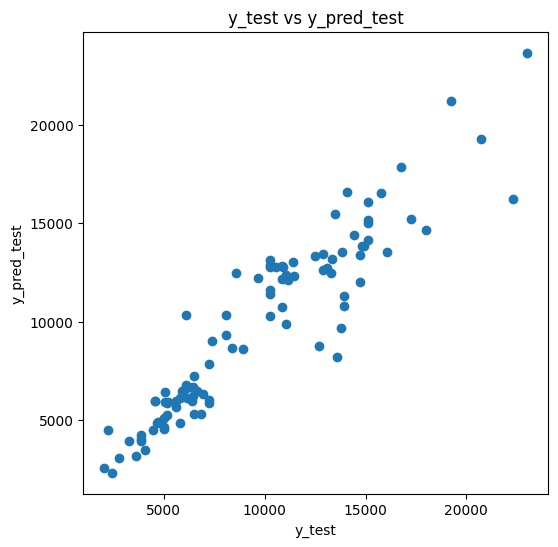

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,1,figsize = (6,6))
ax.set_title('y_test vs y_pred_test')
ax.scatter(x = y_test[:100], y = preds[:100])
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred_test')
    
plt.show()

In [31]:
# save the model
import pickle

# Save the model
with open('final_xgboost-model2.pkl', 'wb') as file:
    pickle.dump(model, file)


In [32]:
# plots to understand about how hyperparameters are tuned and what is the result of each trial
import plotly
optuna.visualization.plot_optimization_history(study)

In [33]:
optuna.visualization.plot_parallel_coordinate(study)

In [34]:
optuna.visualization.plot_slice(study, params=['n_estimators','max_depth','learning_rate','subsample'])

In [35]:
optuna.visualization.plot_param_importances(study)